<a href="https://colab.research.google.com/github/Khalidmamdou7/CMP637-assignments/blob/main/Notebooks/MNIST-autoregressive-models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

## Define utility functions

In [31]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False
use_binary_data = True  # two values only {0, 1} or {0, 255}

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

## Load and visualize the dataset

In [39]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
    if use_binary_data:
        transform = transforms.Compose([
            transforms.PILToTensor(),
            transforms.Lambda(lambda x: (x > 127).to(torch.uint8) * 255)
        ])
    else:
        transform = transforms.Compose([
            transforms.PILToTensor(),
        ])
else:
    if use_binary_data:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: (x > 0.5).float())
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

# This will load the dataset into the folder "datasets" the first time it is run
train_dataset = torchvision.datasets.MNIST(root="datasets", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="datasets", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

dataset = train_dataset

torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.uint8 torch.int64
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0, 255, 255,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0, 255, 255, 255,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,

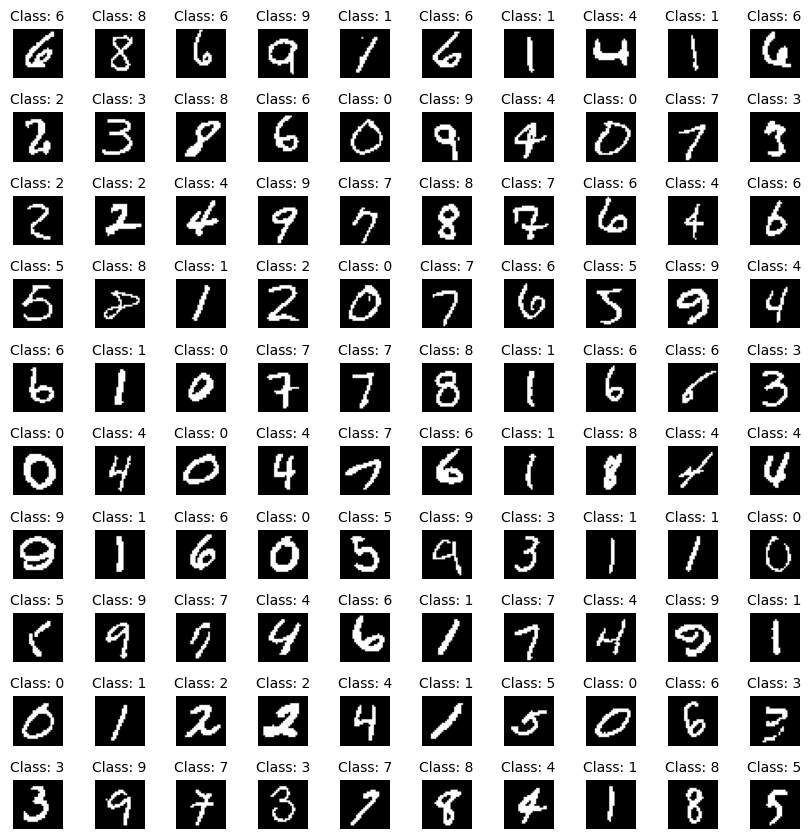

In [40]:
def show_dataset_sample(sample_size: int = 100):
  loader = DataLoader(dataset, batch_size=100, shuffle=True)
  x, y = next(iter(loader))
  print(x.shape, y.shape)
  print(x.dtype, y.dtype)
  print(x.min(), x.max())
  print(x[0])
  print(y[0])
  show_images(x, y)

show_dataset_sample()

## Select a device

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cuda


## Define the model

In [6]:
# TODO: Define your model(s) and loss function(s) here.
# You can add as many cells as you like.
# You can add utility functions related to the model here too.

class FVSBN(nn.Module):
    """
    Fully Visible Sigmoid Belief Network
    """
    def __init__(self, l = 28, w = 28):
        super().__init__()
        self.n_pixels = l * w
        # converting the image from 2d to 1d [28, 28] -> [784]
        self.flatten = nn.Flatten()

        # Create Parameters for each conditional
        # For pixel i, we need i parameters (including bias)
        # Total parameters: 1 + 2 + 3 + ... + n = n(n+1)/2
        weights_scaling_factor = 0.01
        self.params = nn.ParameterList([
            nn.Parameter(torch.randn(i + 1) * weights_scaling_factor) # [bias, alpha_0, alpha_1, .., alpha_i-1]
            for i in range(self.n_pixels)
        ])

        # mask = create_fvsbn_mask(self.n_pixels)
        # self.linear = MaskedLinear( in_features=self.n_pixels, out_features=self.n_pixels, mask=mask )
    def forward(self, x):
        """
        Computes log probability of x
        Args:
            x: [Batch, Channels, Height, Width] [100, 1, 28, 28] with values in [0, 255]
        returns: logits for Bernoulli distribution
        """
        batch_size = x.size(0)
        log_prob = torch.zeros(batch_size, device=x.device)
        x = self.flatten(x)






        return log_prob
        # logits = self.linear(x)
        # return logits


class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask):
        super().__init__(in_features, out_features)
        self.register_buffer("mask", mask)
    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)

def create_fvsbn_mask(n):
    """
    Creates a strictly lower-triangular mask.
    Shape: [n, n]
    """
    return torch.tril(torch.ones(n, n), diagonal=-1)




def fvsbn_loss(logits, x):
    """
    logits: [B, 784]
    x:      [B, 784]
    """
    return F.binary_cross_entropy_with_logits(
        logits, x, reduction="sum"
    ) / x.size(0)




## Define Hyperparameters

In [7]:
# TODO: Define the hyperparameters here.

## Instantiate models and optimizers

In [8]:
# TODO: Instantiate the models and optimizers here.

## Train the model

In [9]:
# TODO: Write the code to train the model here

model = FVSBN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    total_loss = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        x = x.view(x.size(0), -1)   # [B, 784]

        optimizer.zero_grad()
        logits = model(x)
        loss = fvsbn_loss(logits, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}: loss = {total_loss / len(train_loader):.4f}")


NameError: name 'num_epochs' is not defined

## [Optional] Save and/or load the model

In [ ]:
## Optional TODO: Save the model if you want to store your work on disk and load it later

## Write the generation function

In [ ]:
# TODO: Rewrite the following function

# Given a tensor of classes y, this function conditionally generates a tensor images.
# Params:
# - y: A tensor of shape [Batch Size] and type int64 and resides on the CPU memory
# Return: A tensor of shape [Batch Size, 1, Height, Width] and type float32
def generate(y: torch.Tensor) -> torch.Tensor:
  batch_size = y.shape[0]
  return torch.zeros((batch_size, 1, 28, 28), dtype=torch.float32)

## Generate some images and display them

In [ ]:
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)
x = generate(y)
show_images(x, y)

## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).